In [1]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.models.glm import GLM
from icglm.iclamp import IClamp
from icglm.kernels import KernelRect
# from icglm.processes import GeneralCov, OUProcess

%load_ext autoreload
%autoreload 2

### Loading and preprocessing patch clamp data

(<Figure size 864x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f77eb16aa58>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f77eaef7470>))

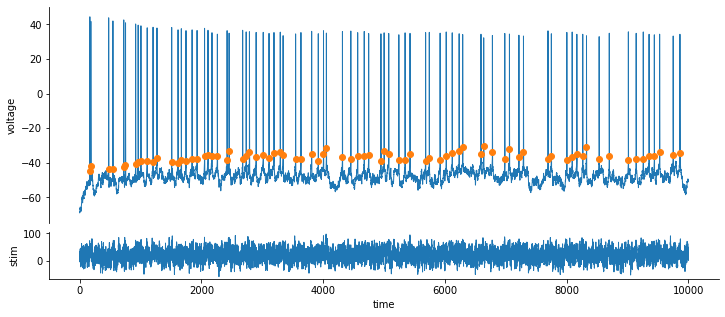

In [2]:
ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1)
ic.set_mask_spikes(thr=0, t_before_spike_peak=0.8)
ic.plot(sweeps=[0], spikes=True)

### Fitting encoding GLM to data

Starting gradient ascent... 

 Iteration 7 of 30 | Elapsed time: 5.01 seconds | log_prior=nan | log_posterior=-3241.41
 
 Iteration 7 of 30 | Converged | Elapsed time: 0.0835 minutes | Log posterior is monotonic 



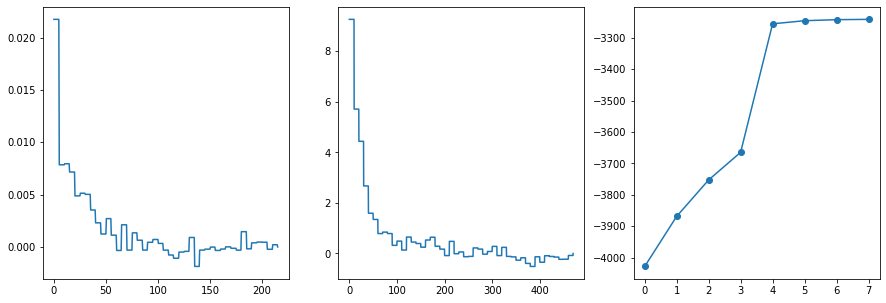

In [4]:
tbins_kappa = np.arange(0, 220, 5)
coefs_kappa0 = 1e-2 * np.exp(-tbins_kappa[:-1] / 50)
tbins_eta = np.arange(0, 480, 10)
coefs_eta0 = 6 * np.exp(-tbins_eta[:-1] / 50)
glm = GLM(u0=15, kappa=KernelRect(tbins_kappa, coefs_kappa0), eta=KernelRect(tbins_eta, coefs_eta0))

newton_kwargs = dict(max_iterations=30, stop_cond=5e-4, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)

optimizer, _ = glm.fit(ic.t, ic.stim, ic.mask_spikes, newton_kwargs=newton_kwargs,verbose=True)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
t_kappa = np.linspace(tbins_kappa[0], tbins_kappa[-1], 500)
ax1.plot(t_kappa, glm.kappa.interpolate(t_kappa))
glm.eta.plot(ax=ax2)
ax3.plot(optimizer.log_posterior_iterations, '-o')

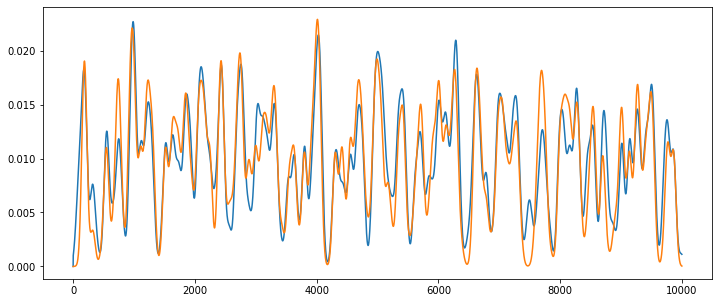

In [5]:
from icglm.kernels import KernelFun
from icglm.spiketrain import SpikeTrain
psth_kernel=KernelFun.gaussian_delta(delta=40)
v, r, mask_spikes = glm.sample(ic.t, ic.stim)
psth_model = SpikeTrain(ic.t, mask_spikes).get_psth(psth_kernel)
psth_exp = SpikeTrain(ic.t, ic.mask_spikes).get_psth(psth_kernel)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ic.t, psth_model)
ax.plot(ic.t, psth_exp)

### Decoding stimulus from spike data and GLM

(2150, 100000) (100000,)
(2150, 100000) (100000,)
(2150, 100000) (100000,)


TypeError: cannot unpack non-iterable AxesSubplot object

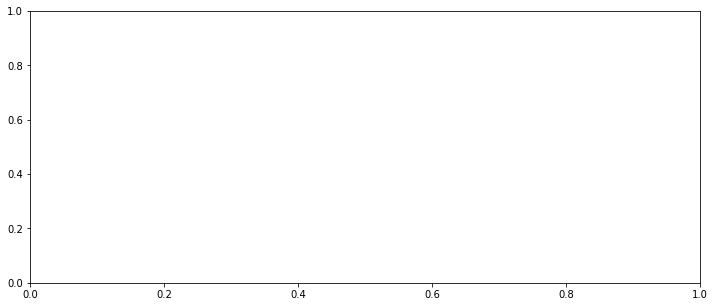

In [7]:
# from icglm.glm_decoding import GLMDecoder
from icglm.processes import OUProcess

mu, sd = np.mean(ic.stim), np.mean(np.std(ic.stim, 0))
ou = OUProcess(mu=mu, sd=sd, tau=3)
stim0 = np.zeros(len(ic.t)) + mu

newton_kwargs = dict(learning_rate=1e-1, stop_cond=5e-4)

stim_dec, optimizer = glm.decode(ic.t, ic.mask_spikes, stim0=stim0, prior=ou, newton_kwargs=newton_kwargs)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ic.t, np.mean(ic.stim, 1))
ax.plot(ic.t, stim_dec)
# I0 = np.zeros(len(glm_fit.ic.t))
# decoder = GLMDecoder(glms=[glm_fit.glm], t=glm_fit.ic.t, mask_spk=[glm_fit.mask_spikes], 
#                      tau=3, Imu=[Imu], Isd=[Isd], I_true=(glm_fit.ic.stim - Imu) / Isd)
# decoder.estimate_MAP_I(I0, prior='OU')
# decoder.plot_decoded_stimulus(t0=4000, tf=6500)

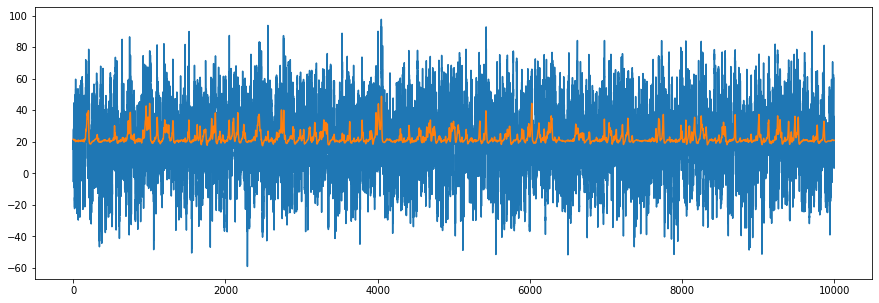

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ic.t, np.mean(ic.stim, 1))
ax.plot(ic.t, stim_dec)